In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt

import os
from collections import OrderedDict
from base import *
from build_model_tf import cascade_model
from config import *
import base
import numpy as np

In [2]:

options = {}

# --------------------------------------------------
# Experiment parameters
# --------------------------------------------------

# image modalities used (T1, FLAIR, PD, T2, ...) 
#options['modalities'] = ['T1', 'FLAIR','GADO','DP','T2']
options['modalities'] = ['FLAIR','T1','T2']

# Select an experiment name to store net weights and segmentation masks
options['experiment'] = 'test_CNN'

# In order to expose the classifier to more challeging samples, a threshold can be used to to select 
# candidate voxels for training. Note that images are internally normalized to 0 mean 1 standard deviation 
# before applying thresholding. So a value of t > 0.5 on FLAIR is reasonable in most cases to extract 
# all WM lesion candidates
options['min_th'] = 0.5

# randomize training features before fitting the model.  
options['randomize_train'] = True

# Select between pixel-wise or fully-convolutional training models. Although implemented, fully-convolutional
# models have been not tested with this cascaded model 
options['fully_convolutional'] = False


# --------------------------------------------------
# model parameters
# --------------------------------------------------

# 3D patch size. So, far only implemented for 3D CNN models. 
options['patch_size'] = (11,11,11)

# percentage of the training vector that is going to be used to validate the model during training
options['train_split'] = 0.25

# maximum number of epochs used to train the model
#options['max_epochs'] = 200

options['max_epochs'] = 400

# maximum number of epochs without improving validation before stopping training (early stopping) 
#options['patience'] = 25
options['patience'] = 10

# Number of samples used to test at once. This parameter should be around 50000 for machines
# with less than 32GB of RAM
options['batch_size'] = 512
#options['batch_size'] = 32

# net print verbosity. Set to zero for this particular notebook, but setting this value to 11 is recommended
options['net_verbose'] = 1

# post-processing binary threshold. After segmentation, probabilistic masks are binarized using a defined threshold.
options['t_bin'] = 0.8

# The resulting binary mask is filtered by removing lesion regions with lesion size before a defined value
options['l_min'] = 5


In [3]:
options['test_name'] = 'cnn_' + options['experiment'] + '.nii.gz'

In [4]:
options['weight_paths'] = os.getcwd()
model = cascade_model(options)
model[0].summary()
model[1].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 11, 11, 11, 32)    2624      
_________________________________________________________________
batch_normalization (BatchNo (None, 11, 11, 11, 32)    128       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 5, 5, 5, 32)       0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 5, 5, 5, 64)       55360     
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 5, 5, 64)       256       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 2, 2, 2, 64)       0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0

In [5]:
#Preload model weights
checkpoint_path1 = "models/model1.ckpt"
checkpoint_path2 = "models/model2.ckpt"
model[0].load_weights(checkpoint_path1)
model[1].load_weights(checkpoint_path2)

In [8]:
# TEST X DATA
test_vec = [9,13,14]
train_folder = '../data/miccai2016/Preprocessed_training_dataset/'
test_x_data = {}
for i in test_vec:
    subj_name = 's' + str(i+1)
    print("Testing subject" + subj_name)
    test_x_data[subj_name] = {'FLAIR': train_folder + subj_name + '/FLAIR_preprocessed.nii.gz', 
    #                         'DP': train_folder + subj_name + '/DP_preprocessed.nii.gz',
    #                         'GADO': train_folder + subj_name +  '/GADO_preprocessed.nii.gz', 
                             'T1': train_folder + subj_name +  '/T1_preprocessed.nii.gz',
                            'T2': train_folder + subj_name +  '/T2_preprocessed.nii.gz'}
    #                              }


    options['test_folder'] = train_folder
    options['test_scan'] = subj_name
    out_seg = test_cascaded_model(model, test_x_data, options)

    out_file_name = '../results/' + subj_name + '_output_segmentation.npy'
    np.save(out_file_name,out_seg)
    test_x_data = {}

Testing subjects10
    --> testing the model
Testing subjects14
    --> testing the model
Testing subjects15
    --> testing the model


dict_keys(['FLAIR', 'T1', 'T2'])

## Test the model

(128, 224, 256)


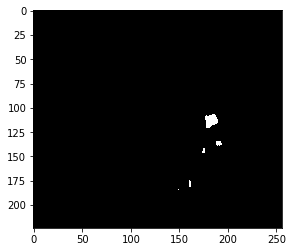

In [11]:
#Load labels
n = 50
name = "data/miccai2016_unprocessed/s10/Consensus.nii.gz"
labels = load_nii(name).get_fdata().astype(dtype=np.bool)
plt.imshow(labels[n,:,:], cmap='gray')
print(labels.shape)

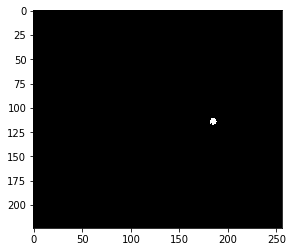

In [12]:
#Load the resulting automatic segmentation
my_seg = np.load('../results/s10_output_segmentation.npy')
plt.imshow(my_seg[n,:,:], cmap='gray')

In [13]:
from metrics import *
DSC(my_seg,labels)

0.17705108359133126

In [14]:
vol_dif(my_seg,labels)

6.834188034188034

In [15]:
TPR(my_seg, labels)

0.09982544185031639

In [16]:
PPV(my_seg, labels)

0.782051282051282

In [17]:
test_ndx = [10, 14, 15]
dscs = []
vds = []
tprs = []
ppvs = []

for ndx in test_ndx:
    name = "../data/miccai2016/Unprocessed_training_dataset/TrainingDataset_MSSEG/s" + str(ndx) + "/Consensus.nii.gz"
    labels = load_nii(name).get_fdata().astype(dtype=np.bool)
    my_seg = np.load('../results/s'+ str(ndx) + '_output_segmentation.npy')
    dscs.append(DSC(my_seg,labels))
    vds.append(vol_dif(my_seg,labels))
    tprs.append(TPR(my_seg, labels))
    ppvs.append(PPV(my_seg, labels))

print("Mean DSC: {0}".format(np.mean(dscs)))

Mean DSC: 0.17224895057789213


In [18]:
print("Mean VD: {0}".format(np.mean(vds)))
print("Mean TPR: {0}".format(np.mean(tprs)))
print("Mean PPV: {0}".format(np.mean(ppvs)))

Mean VD: 30.3708450887265
Mean TPR: 0.11482705598916598
Mean PPV: 0.7393973408696556
